<a href="https://colab.research.google.com/github/eduardoalbertorg/UAG_reconocimiento_patrones/blob/main/Video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
from google.colab.patches import cv2_imshow

In [2]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [5]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  cv2_imshow(gray)

  img_hsv =cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
  cv2_imshow(img_hsv)
    
  bordes = cv2.Canny(img, 50, 200)
  cv2_imshow(bordes)

  dst= cv2.GaussianBlur(img,(3,3),0,0,0)
  cv2_imshow(dst)

  blur1 = cv2.bilateralFilter(img,9,75,75)
  cv2_imshow(blur1)

  median = cv2.medianBlur(img,3)
  cv2_imshow(median)

  kernel = np.ones((5,5),np.float32)/25
  dst = cv2.filter2D(img,-1,kernel)
  cv2_imshow(dst)

  imgg = cv2.equalizeHist(gray)
  cv2_imshow(imgg)

  height, width = img.shape[0:2]

  res = cv2.resize(img,(2*width, 2*height), interpolation = cv2.INTER_CUBIC)
  cv2_imshow(res)

  res1 = cv2.resize(img,(2*width, 2*height), interpolation = cv2.INTER_LINEAR)
  cv2_imshow(res1)

  res2 = cv2.resize(img,(2*width, 2*height), interpolation = cv2.INTER_NEAREST)
  cv2_imshow(res2)

  rotationMatrix = cv2.getRotationMatrix2D((width/2, height/2), 90, .5)
  rotatedImage = cv2.warpAffine(img, rotationMatrix, (width, height))
  cv2_imshow(rotatedImage)

  laplacian = cv2.Laplacian(img,cv2.CV_64F)
  cv2_imshow(laplacian)

  sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
  sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
    #sobelxy= cv2.Sobel(frame,cv2.CV_64F,1,1,Ksize=5)
  cv2_imshow(sobelx)
  cv2_imshow(sobely)
    #cv2.imshow('Sobel xy',sobelxy)

  ret,thresh1 = cv2.threshold(gray,127,255,cv2.THRESH_BINARY)
    #ret,thresh2 = cv2.threshold(frame,127,255,cv2.THRESH_BINARY_INV)
    #ret,thresh3 = cv2.threshold(frame,127,255,cv2.THRESH_TRUNC)
    #ret,thresh4 = cv2.threshold(frame,127,255,cv2.THRESH_TOZERO)
    #ret,thresh5 = cv2.threshold(frame,127,255,cv2.THRESH_TOZERO_INV)
  th3 = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,21,4)

  cv2_imshow(thresh1)
  cv2_imshow(th3)


  kernel = np.ones((5,5),np.uint8)
  erosion = cv2.erode(img,kernel,iterations = 2)
  cv2_imshow(erosion)

  dilation = cv2.dilate(img,kernel,iterations = 2)
  cv2_imshow(dilation)

  opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
  cv2_imshow(opening)

  closing = cv2.morphologyEx(img,cv2.MORPH_CLOSE, kernel)
  cv2_imshow(closing)
  
  gradient = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernel)
  cv2_imshow(gradient)

  tophat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)
  blackhat = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, kernel)

  #print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  #faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  #for (x,y,w,h) in faces:
  #    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

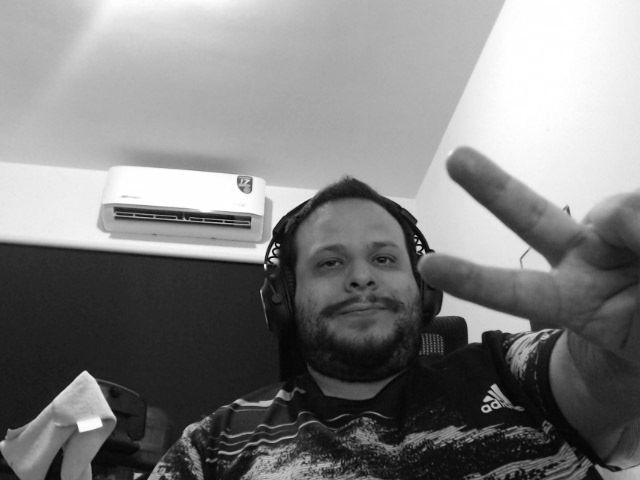

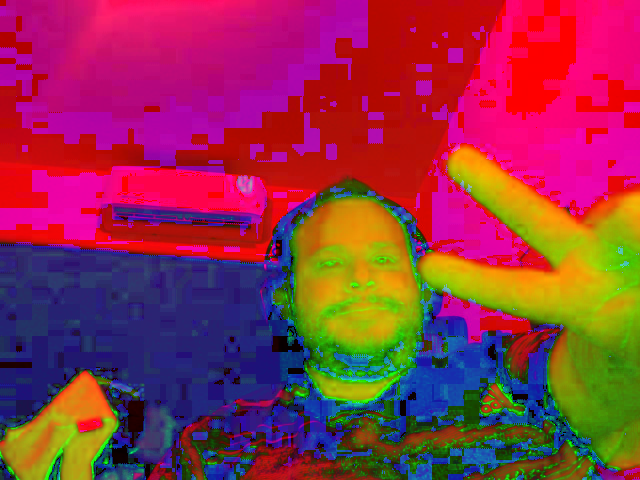

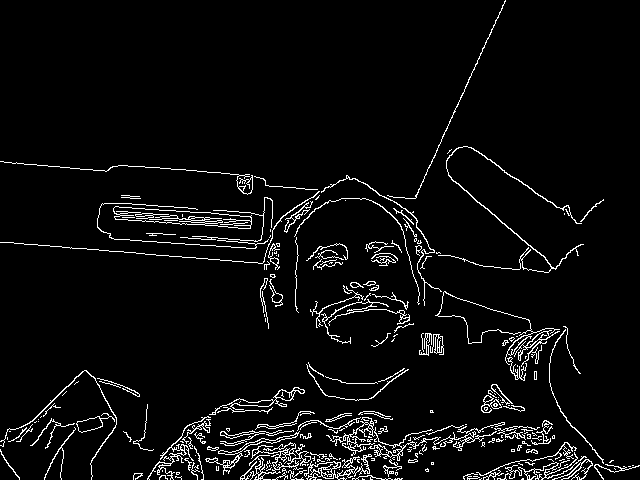

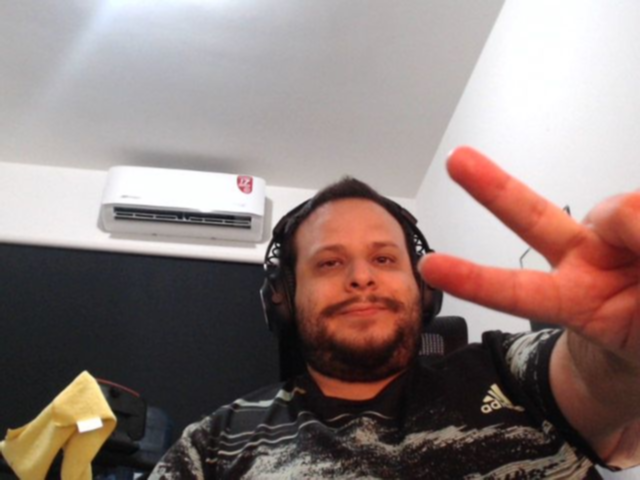

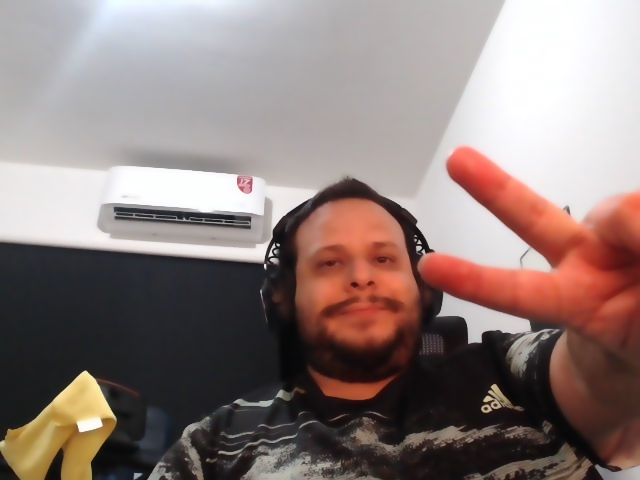

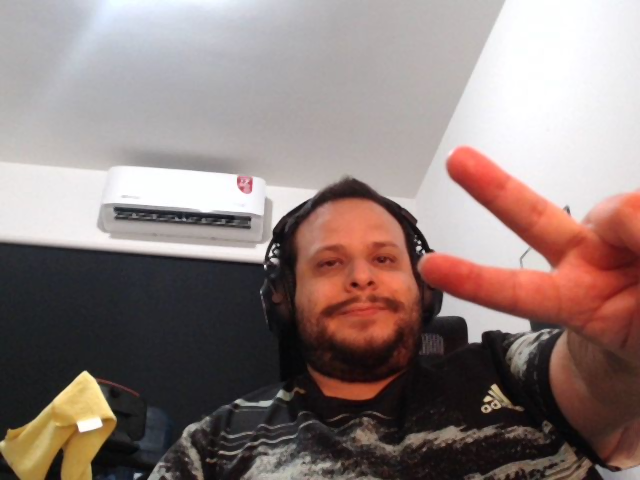

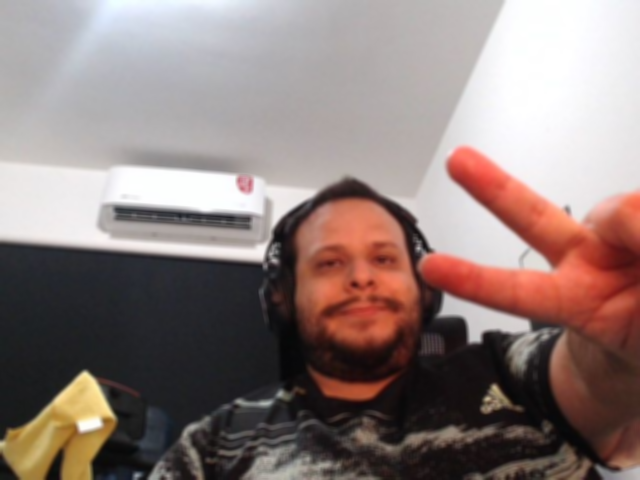

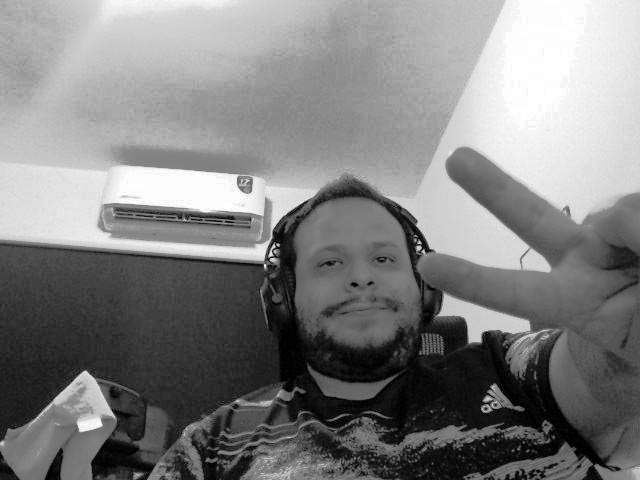

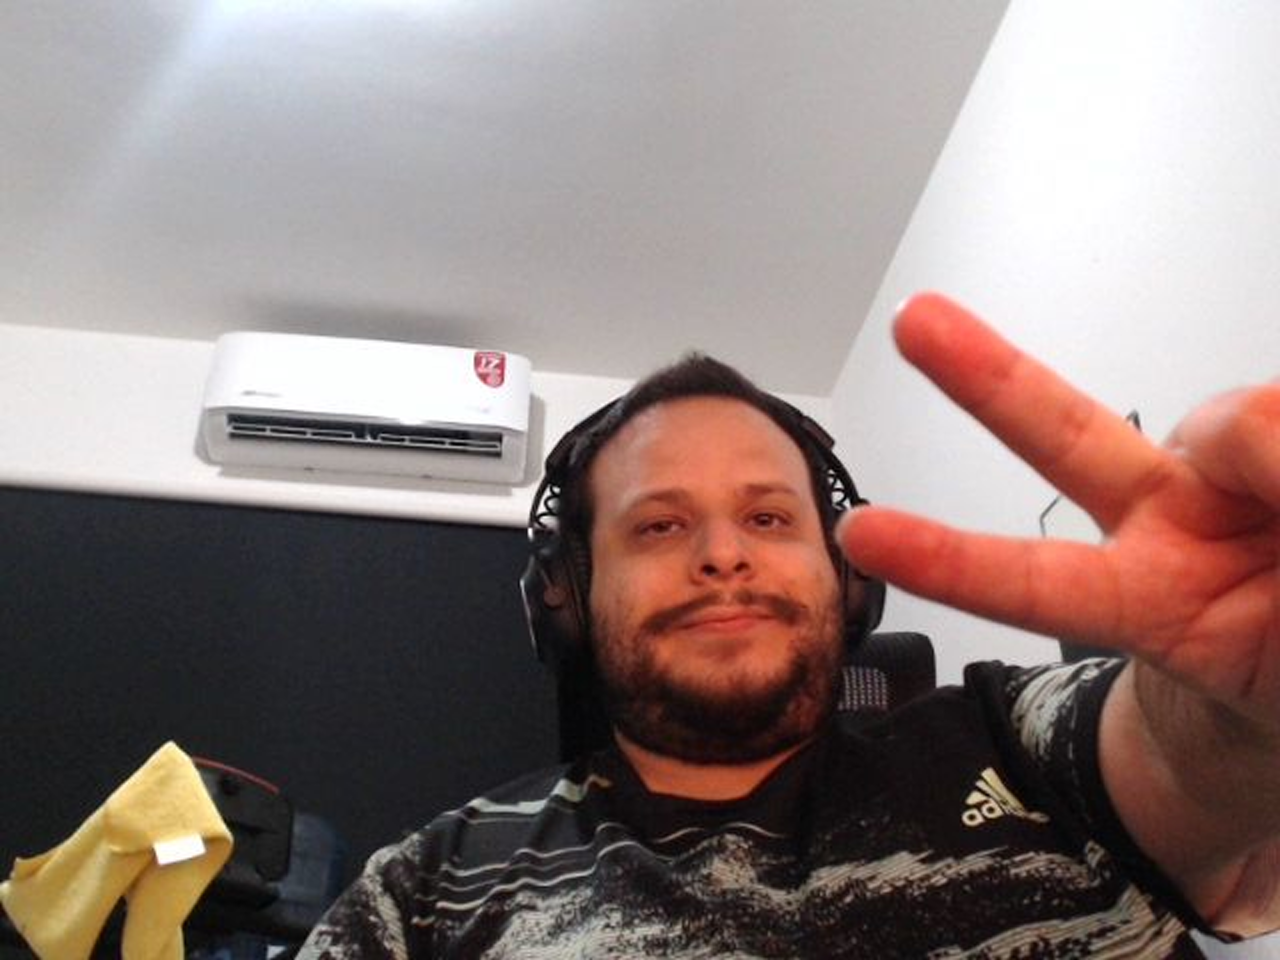

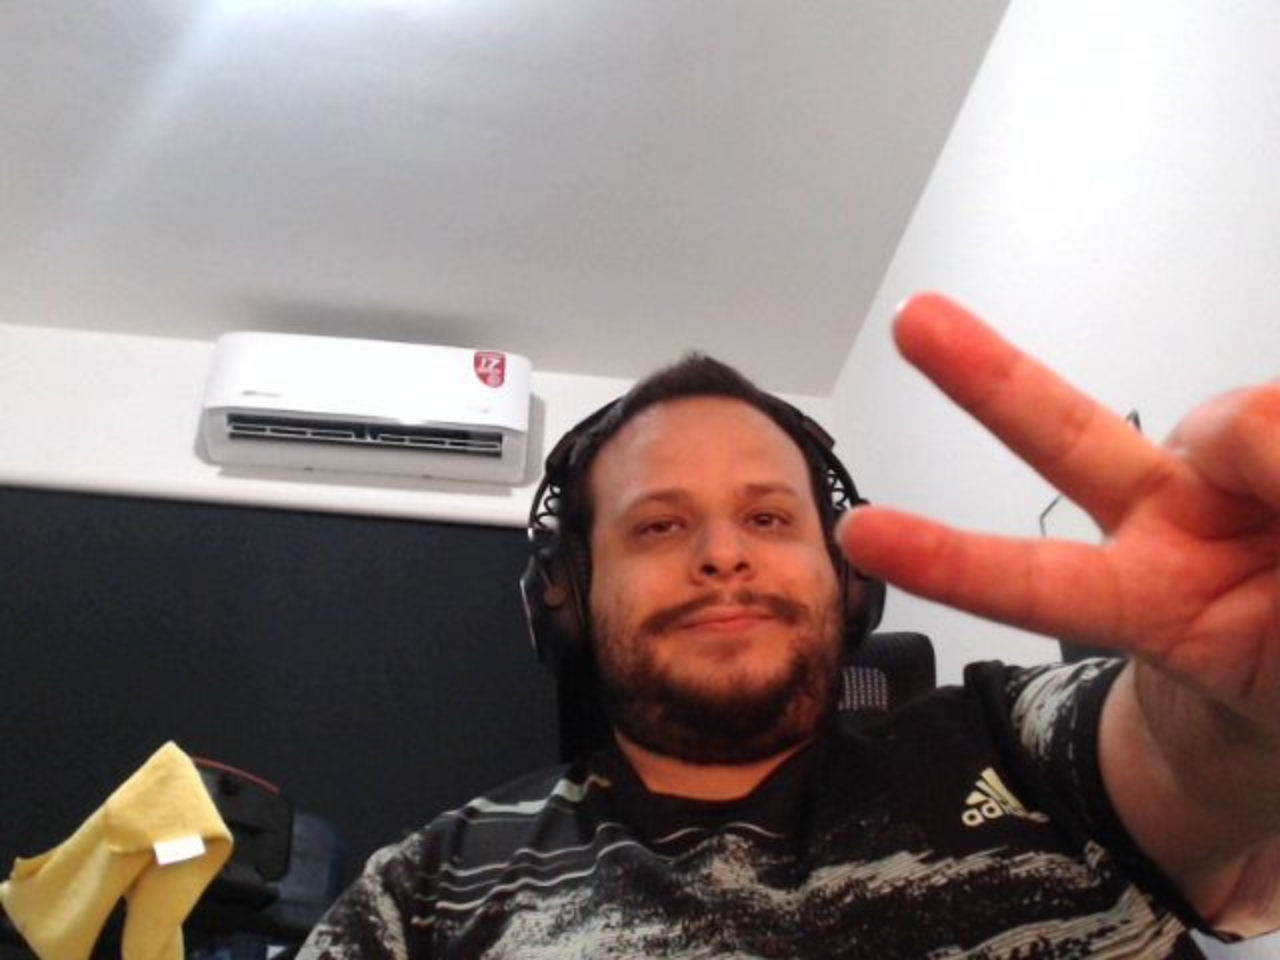

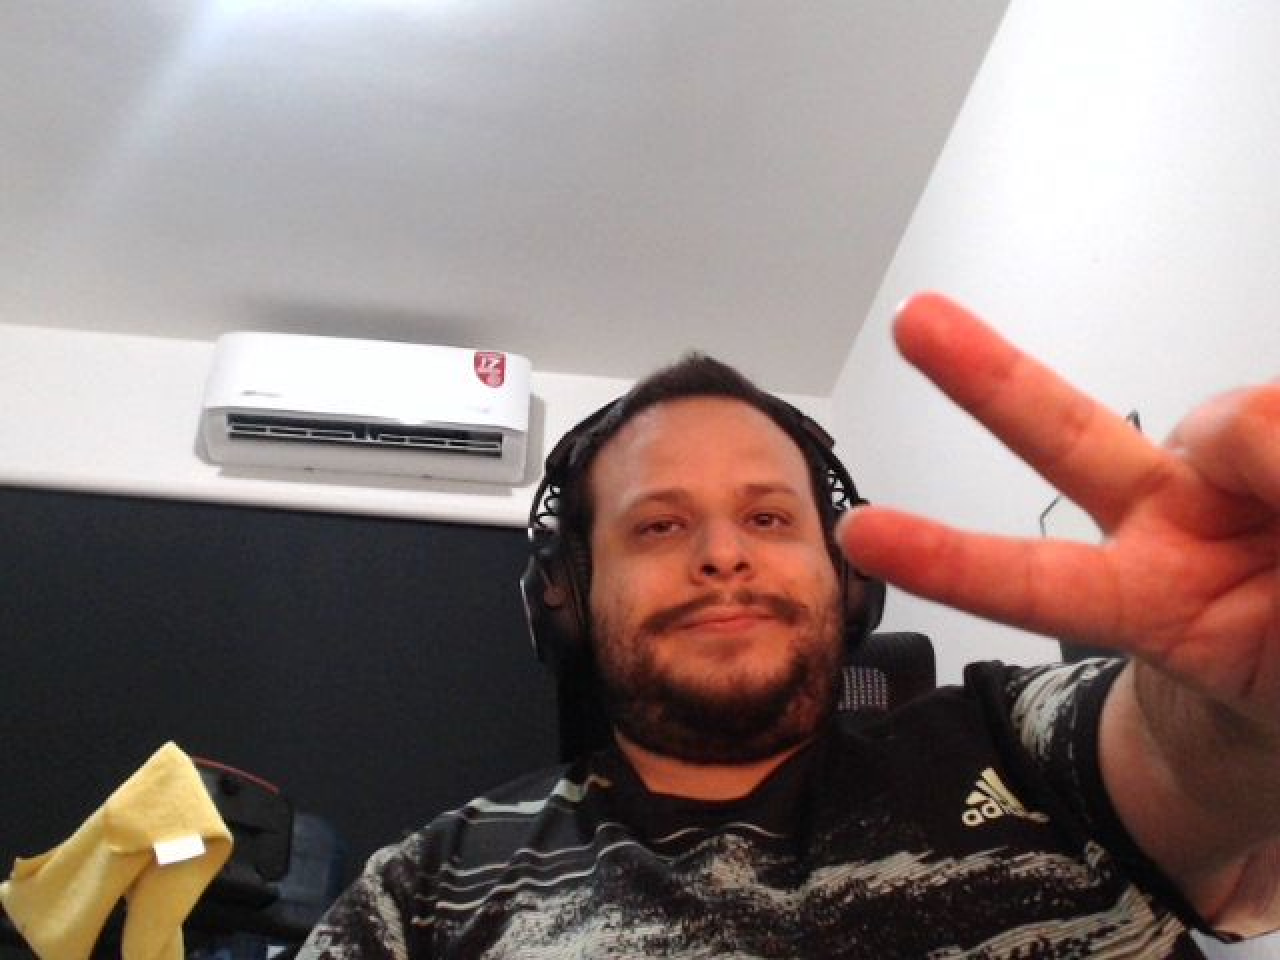

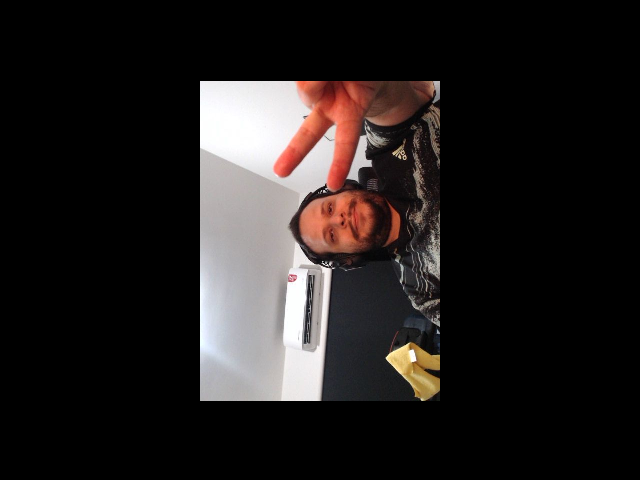

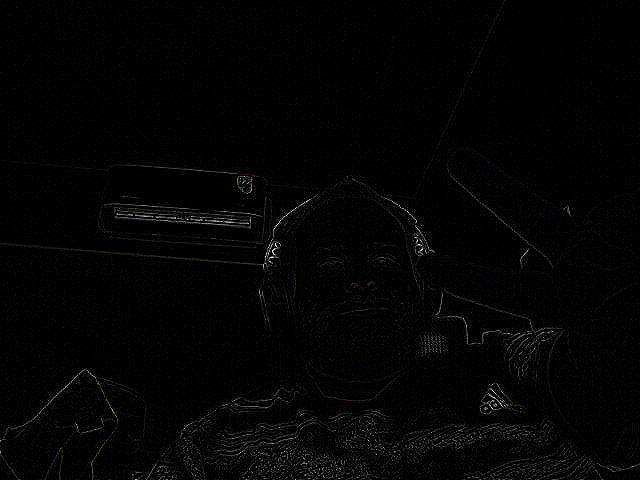

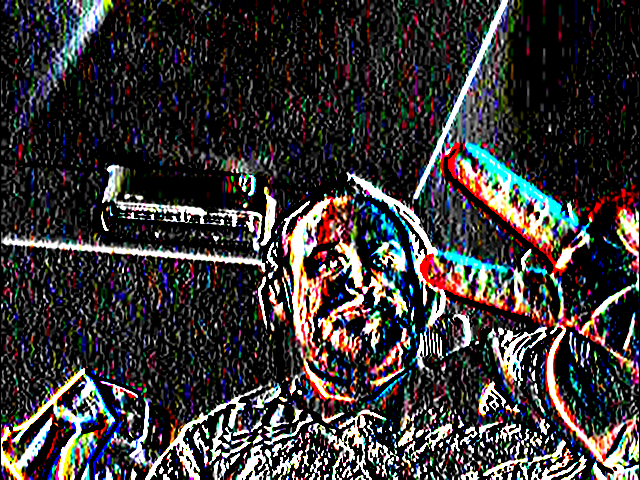

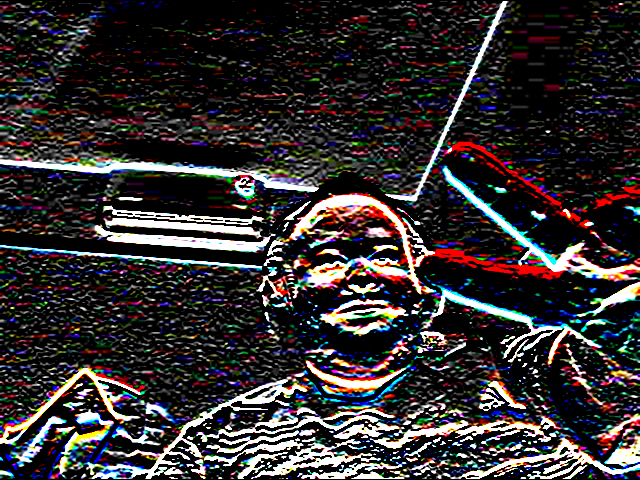

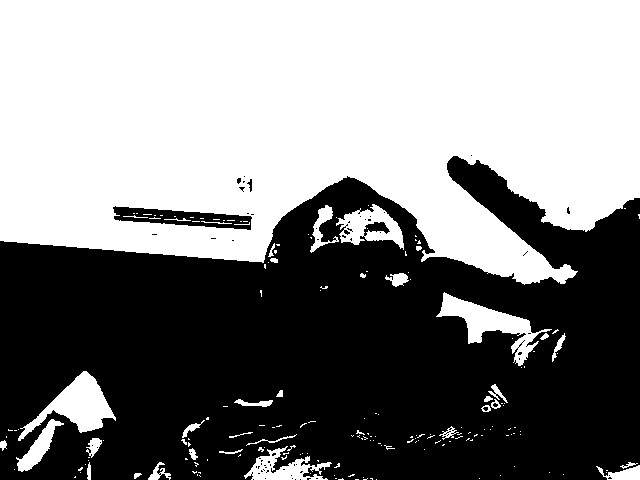

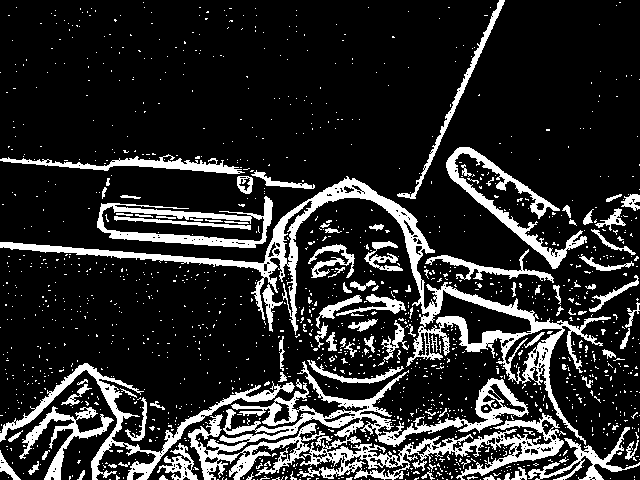

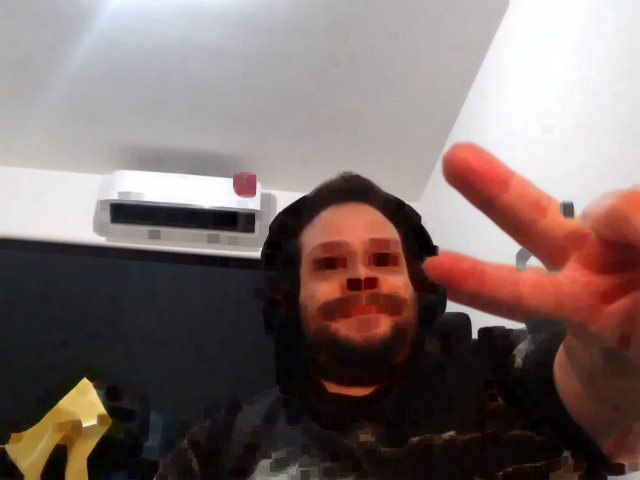

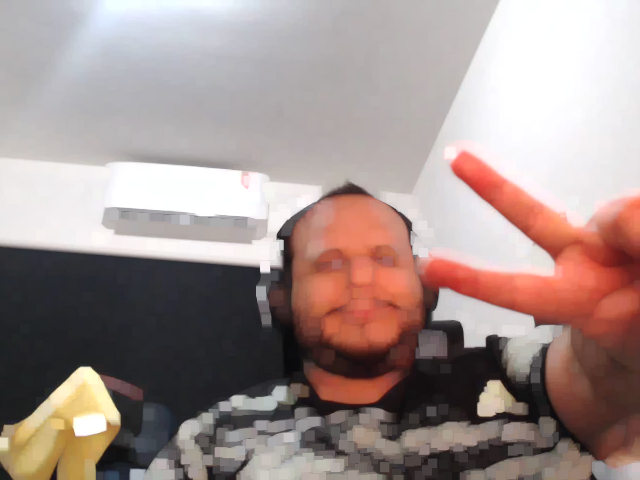

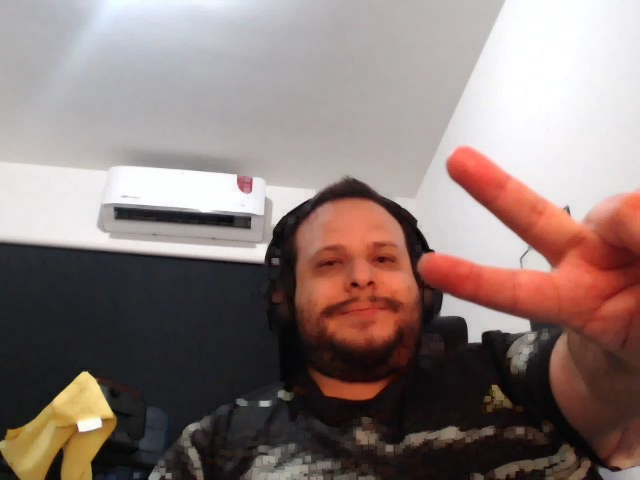

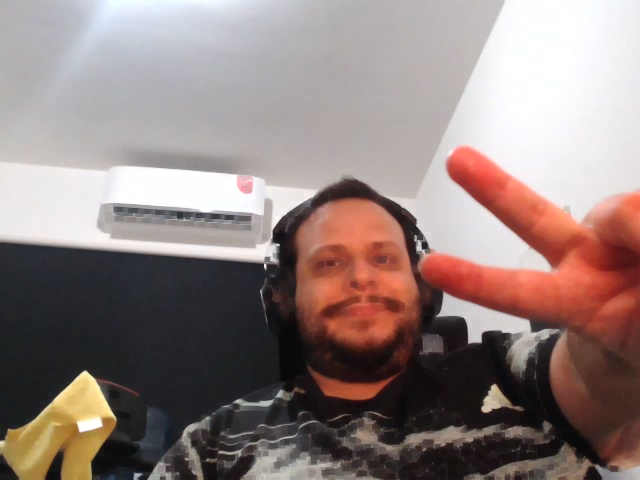

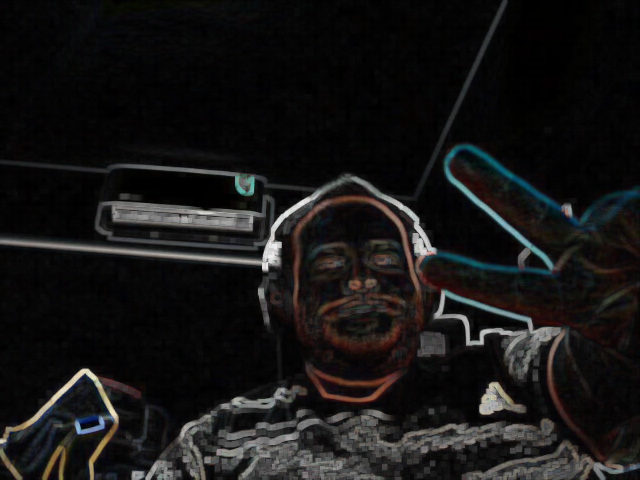

Saved to photo.jpg


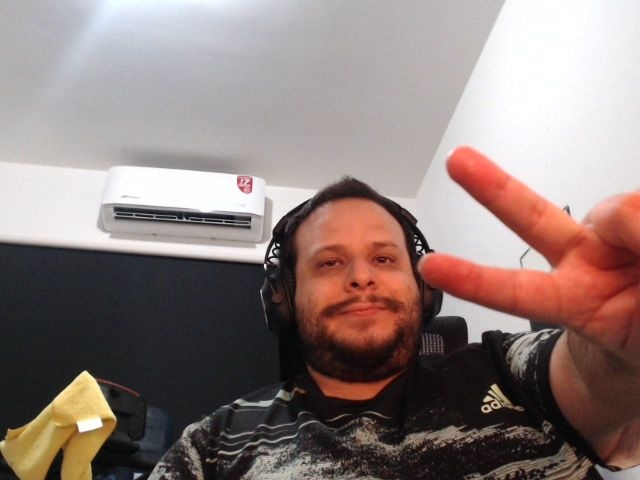

In [6]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))